# Uncertainty Calibration（不确定性校准）

> 本 notebook 针对 `results/feature_error_std.txt` 中的样本级别 (error_x, error_y, std) 做 **uncertainty calibration**。

我们关心的问题是：模型给出的不确定性/标准差 `std` 是否与真实误差的分布一致？如果一致，那么：
- 预测的区间/置信区域应该拥有正确的覆盖率（coverage）。
- 归一化残差（例如 $z = \frac{e}{\sigma}$）在统计上应接近理论分布（Gaussian / Rayleigh / Chi 分布）。

下面给出两类常用校准方法，并结合二维误差（x/y）与“瑞雷分布”讨论分位值与覆盖率的正确计算方式。

## 0. 数据与“std”的含义（需要先澄清）

文件包含列：`error_x, error_y, px, py, density, intensity, std`。这里的 `std` 是你统计得到的标准差（或模型预测的 scale）。它可能对应：

- **(A) 每个样本的同一个标量 σ**：假设 $e_x \sim \mathcal{N}(0,\sigma^2),\ e_y \sim \mathcal{N}(0,\sigma^2)$（各向同性、同方差），并且 `std` 就是该样本的 σ。
- **(B) 每个样本每轴一套 σ_x/σ_y**：但当前文件只有一个 `std`，所以更像 (A)。
- **(C) “分箱统计 std”**：即你先按某类特征（distance/intensity/density）聚类/分箱，再对 bin 内的误差求 std，把这个 std 再回填到 bin 内所有样本。此时 `std` 是“组统计量”，不是模型的 per-sample predictive std。

本 notebook 会用以下诊断来验证 `error` 和 `std` 是否“匹配”：
- 归一化残差 $z_x=e_x/\sigma$、$z_y=e_y/\sigma$ 是否近似稳定（均值≈0、方差≈1）。
- 二维误差幅值 $r=\sqrt{e_x^2+e_y^2}$ 的归一化 $z_r=r/\sigma$ 是否接近 Rayleigh/Chi 分布形状。

## 1) 校准目标：coverage/quantile 与 reliability 的统一视角

假设你给每个样本一个预测分布 $p(e\mid\sigma)$（或参数化分布 $p_\theta$），校准的核心就是：

$$\Pr\big(e \in \mathcal{R}_\alpha(\sigma)\big) = \alpha,\ \ \forall\alpha\in(0,1)$$

其中 $\mathcal{R}_\alpha(\sigma)$ 是“理论上应该覆盖 $\alpha$ 概率质量的集合”。

典型选择：

### 1.1 一维（每轴）Gaussian 的 coverage

若 $e_x\sim\mathcal{N}(0,\sigma^2)$，那么区间 $[-k\sigma,\ k\sigma]$ 的覆盖率为：

$$\alpha(k)=\Pr(|e_x|\le k\sigma)=2\Phi(k)-1$$

因此给定目标覆盖率 $\alpha$，对应 $k=\Phi^{-1}\big((1+\alpha)/2\big)$。

### 1.2 二维各向同性 Gaussian → 半径 r 的 Rayleigh（你提到的关键点）

如果 $(e_x,e_y)$ 独立且同方差：

$$e_x,e_y\overset{i.i.d.}{\sim}\mathcal{N}(0,\sigma^2)$$

那么半径 $r=\sqrt{e_x^2+e_y^2}$ 服从 **Rayleigh** 分布（也可看作 scaled Chi 分布，2 个自由度）：

$$\frac{r}{\sigma} \sim \text{Rayleigh}(1),\ \ f(z)=z\exp(-z^2/2),\ z\ge 0$$

其 CDF：

$$\Pr(r\le t)=1-\exp\left(-\frac{t^2}{2\sigma^2}\right)$$

因此要构造“应覆盖 $\alpha$ 的圆形置信区域”（radius 版本）：

$$t_\alpha(\sigma)=\sigma\sqrt{-2\ln(1-\alpha)}$$

这就是你提醒的点：**两个正态分量的 RMS/半径不再是正态**，用一维分位值会算错 coverage。

### 1.3 椭圆区域（更一般：协方差 Σ）

若 $e\sim\mathcal{N}(0,\Sigma)$，则马氏距离：

$$m^2=e^T\Sigma^{-1}e \sim \chi^2_{d}$$

二维下 $d=2$，所以 $\alpha$ 覆盖的椭圆区域满足 $m^2\le \chi^2_{2}(\alpha)$。

当前数据只有一个 `std`，我们默认先做各向同性圆形区域（Rayleigh），并额外提供“逐轴Gaussian”的对照。

## 2) 两种实做的校准评估/校准方式

### 方法 A：Coverage / Quantile calibration（连续 α 曲线）

核心思路：对一系列 $\alpha\in(0,1)$，比较
- 经验覆盖率（empirical coverage）：$\hat c(\alpha)=\frac{1}{N}\sum_i \mathbf{1}\{e_i\in\mathcal{R}_\alpha(\sigma_i)\}$
- 理论覆盖率：$c(\alpha)=\alpha$

然后绘制 reliability curve：$\hat c(\alpha)$ vs $\alpha$。常用摘要指标：
- **ACE**：$\int_0^1 |\hat c(\alpha)-\alpha|d\alpha$（离散近似）
- 或者在若干 anchor points（例如 0.5/0.8/0.9/0.95）上报告误差。

特点：不需要分箱；直接验证“你给的分布形状/scale 是否对”。

### 方法 B：按预测不确定性分箱（binning reliability diagram）

把样本按 `std`（或任意 uncertainty proxy）排序并分到 $B$ 个 bin（通常用 equal-count 更稳），每个 bin 内再比较：
- 预测的典型尺度（例如 $\bar\sigma_b$ 或 median(σ)）
- 真实误差的尺度（例如 $\text{RMSE}(e)$，或 $\text{median}(|e|)$ / $q_{\alpha}(|e|)$）

如果是二维幅值 $r$，则比较 $q_\alpha(r)$ 与 $t_\alpha(\sigma)$ 更合理。

这种方法特别适合你提到的情况 (C)：**如果 `std` 本身就是分箱统计量**，那 binning 反而更“同源”。

## 3) 文献/参考（校准思想来源）

这里给几类与你的需求最贴近的参考（不局限于分类 ECE，而是“连续变量/回归不确定性”）：

- **Kuleshov et al., 2018**：*Accurate Uncertainties for Deep Learning Using Calibrated Regression*（回归分位值/coverage 校准的经典工作，提出用校准映射让预测分布满足 coverage）。
- **Gneiting & Raftery, 2007**：*Strictly Proper Scoring Rules, Prediction, and Estimation*（概率预测的正确评估：NLL/CRPS 等；解释为何 coverage 与 proper scoring 相关但不等价）。
- **Levi et al., 2022 / various**（不确定性可靠性图、回归 ECE/ACE 的实践文章很多；我们在实现里采用通用 reliability curve 思路，不依赖特定网络结构）。
- **Rayleigh/Chi 分布**：任何统计教材/分布手册都可作为依据：二维 i.i.d Gaussian 的半径服从 Rayleigh；一般 $\chi^2$ 与马氏距离用于椭圆置信区域。

## 4) 本 notebook 中将做什么

1. 读取数据并验证 `std` 与 error 的关系（包括 $z_x,z_y,z_r$ 的分布形状）。
2. 实现两种 calibration 评估：
   - 方法 A：coverage curve（逐轴 Gaussian 与 二维 Rayleigh 两个版本）。
   - 方法 B：按 `std` 分箱的可靠性图（同样给逐轴/半径两个版本）。
3. 可选：给出一个简单的“scale recalibration”映射（例如学习 $\hat\sigma' = a\sigma$ 或 isotonic regression），观察校准改善（保持风险较低、易解释）。

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

DATA_PATH = "results/feature_error_std.txt"

# The file uses tabs AND extra tab padding, so read with regex separator and drop empty columns.
df_raw = pd.read_csv(DATA_PATH, sep=r"\t+", engine="python")
df_raw.columns = [c.strip() for c in df_raw.columns]
df = df_raw.loc[:, ~df_raw.columns.str.contains(r"^Unnamed")].copy()

# Ensure numeric dtype
for c in df.columns:
    df[c] = pd.to_numeric(df[c], errors="coerce")

print("Loaded shape:", df.shape)
print("Columns:", df.columns.tolist())

# Backward/forward compatibility: require these columns
required = ["error_x", "error_y"]
for r in required:
    if r not in df.columns:
        raise ValueError(f"Missing required column: {r}")

# New columns after stdExtract.ipynb update
for name in ["std", "std_x", "std_y", "std_r"]:
    if name in df.columns:
        print(f"{name}: mean={df[name].mean():.4f}, std={df[name].std():.4f}, min={df[name].min():.4f}, max={df[name].max():.4f}")
    else:
        print(f"WARNING: column {name} not found")

df.head()

Loaded shape: (21025, 10)
Columns: ['error_x', 'error_y', 'px', 'py', 'density', 'intensity', 'std', 'std_x', 'std_y', 'std_r']
std: mean=0.1501, std=0.0621, min=0.0530, max=0.4350
std_x: mean=0.1199, std=0.0537, min=0.0370, max=0.3670
std_y: mean=0.0862, std=0.0411, min=0.0200, max=0.2810
std_r: mean=0.0918, std=0.0401, min=0.0270, max=0.3290


,error_x,error_y,px,py,density,intensity,std,std_x,std_y,std_r
0,0.253,-0.048,34.38,-3.18,8.648,0.123,0.155,0.141,0.065,0.075
1,0.135,0.036,13.22,-1.00,59.973,0.131,0.080,0.063,0.049,0.050
2,-0.004,-0.018,38.26,15.71,7.227,0.021,0.220,0.168,0.142,0.127
3,-0.100,0.161,31.73,2.61,4.733,0.083,0.214,0.151,0.151,0.117
4,-0.145,0.289,19.72,12.54,39.031,0.069,0.170,0.116,0.124,0.097


error_x      0.0
error_y      0.0
px           0.0
py           0.0
density      0.0
intensity    0.0
std          0.0
std_x        0.0
std_y        0.0
std_r        0.0
dtype: float64
            error_x       error_y            px            py       density  \
count  21025.000000  21025.000000  21025.000000  21025.000000  21025.000000   
mean       0.046743      0.027362     23.661211      2.245815     53.010965   
std        0.135742      0.098842     12.508545      7.824096     94.612069   
min       -1.125000     -0.951000     -0.180000    -39.860000      0.078000   
25%       -0.013000     -0.016000     13.860000     -2.890000      5.554000   
50%        0.049000      0.022000     22.660000      3.060000     16.645000   
75%        0.110000      0.065000     32.200000      6.420000     57.610000   
max        0.743000      0.943000     70.350000     34.190000    911.932000   

          intensity           std         std_x         std_y         std_r  
count  21025.000000  2102

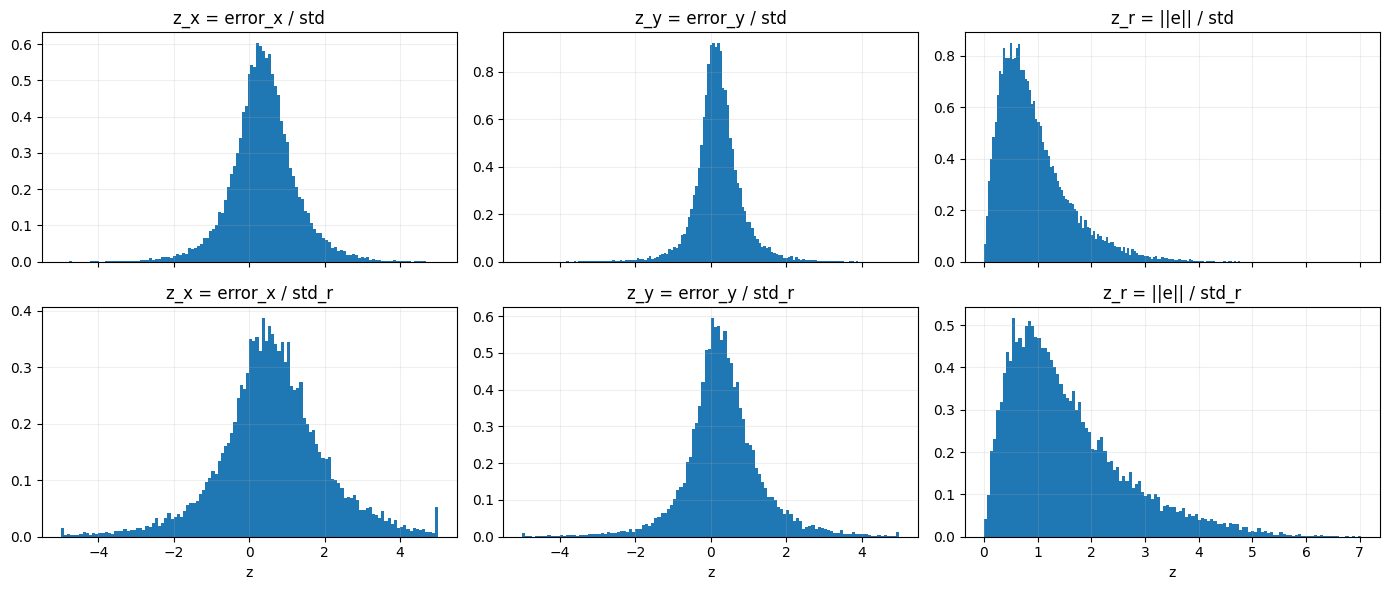

In [2]:
# Basic sanity checks: missing values and some quick relationships
print(df.isna().mean().sort_values(ascending=False).head(15))
print(df.describe())

# Construct derived error magnitudes
df["err_abs_x"] = df["error_x"].abs()
df["err_abs_y"] = df["error_y"].abs()
df["err_r"] = np.sqrt(df["error_x"]**2 + df["error_y"]**2)

# Compare correlations with different 'std' definitions
std_candidates = [c for c in ["std", "std_r", "std_x", "std_y"] if c in df.columns]
for sname in std_candidates:
    print("\n--- Correlation vs", sname, "---")
    for col in ["err_abs_x", "err_abs_y", "err_r"]:
        valid = df[[col, sname]].dropna()
        r = np.corrcoef(valid[col], valid[sname])[0, 1] if len(valid) > 1 else np.nan
        rho = stats.spearmanr(valid[col], valid[sname], nan_policy="omit").correlation
        print(f"{col}: Pearson r={r:.3f}, Spearman rho={rho:.3f} (n={len(valid)})")

# Normalized residual diagnostics: compare using std (combined RMS) vs std_r (radial std)
if "std" in df.columns:
    df["z_x_std"] = df["error_x"] / df["std"]
    df["z_y_std"] = df["error_y"] / df["std"]
    df["z_r_std"] = df["err_r"] / df["std"]
if "std_r" in df.columns:
    df["z_x_stdr"] = df["error_x"] / df["std_r"]
    df["z_y_stdr"] = df["error_y"] / df["std_r"]
    df["z_r_stdr"] = df["err_r"] / df["std_r"]

def summarize_z(name):
    v = df[name].replace([np.inf, -np.inf], np.nan).dropna()
    return f"mean={v.mean():.3f}, std={v.std():.3f}, median={v.median():.3f}, n={len(v)}"

print("\n--- z summaries (using std) ---")
for name in ["z_x_std", "z_y_std", "z_r_std"]:
    if name in df.columns:
        print(name, ":", summarize_z(name))

print("\n--- z summaries (using std_r) ---")
for name in ["z_x_stdr", "z_y_stdr", "z_r_stdr"]:
    if name in df.columns:
        print(name, ":", summarize_z(name))

# Visualize z distributions side-by-side
fig, ax = plt.subplots(2, 3, figsize=(14, 6), sharex='col')

def hist_on(a, data, title, clip):
    v = data.replace([np.inf, -np.inf], np.nan).dropna().clip(*clip)
    a.hist(v, bins=120, density=True)
    a.set_title(title)
    a.grid(True, alpha=0.2)

if "z_x_std" in df.columns:
    hist_on(ax[0,0], df["z_x_std"], "z_x = error_x / std", (-5, 5))
    hist_on(ax[0,1], df["z_y_std"], "z_y = error_y / std", (-5, 5))
    hist_on(ax[0,2], df["z_r_std"], "z_r = ||e|| / std", (0, 8))
if "z_x_stdr" in df.columns:
    hist_on(ax[1,0], df["z_x_stdr"], "z_x = error_x / std_r", (-5, 5))
    hist_on(ax[1,1], df["z_y_stdr"], "z_y = error_y / std_r", (-5, 5))
    hist_on(ax[1,2], df["z_r_stdr"], "z_r = ||e|| / std_r", (0, 8))

for j in range(3):
    ax[1,j].set_xlabel("z")
plt.tight_layout()
plt.show()

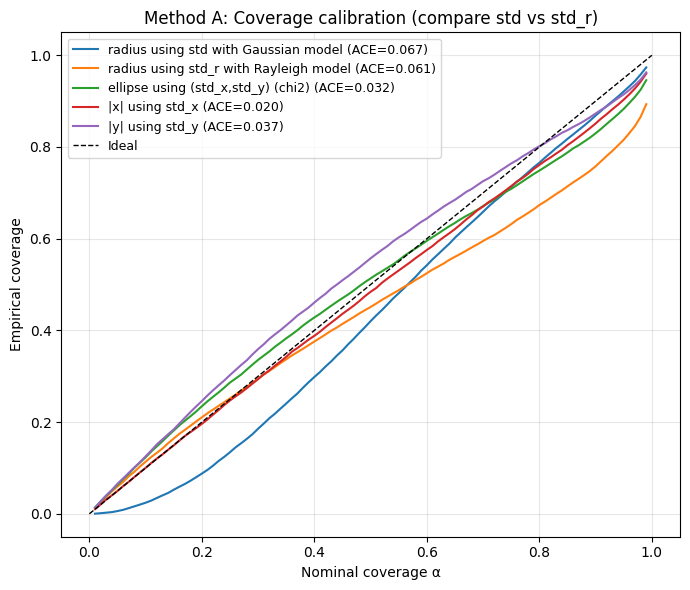

In [ ]:
# -----------------------------
# Method A: Coverage / Quantile calibration (continuous curve)
# Compare using std (combined RMS) vs std_r (radial std)
# -----------------------------
def coverage_curve_gaussian_1d(errors: np.ndarray, sigma: np.ndarray, alphas: np.ndarray):
    """Empirical coverage for symmetric interval [-k*sigma, k*sigma] where k depends on alpha."""
    errors = np.asarray(errors)
    sigma = np.asarray(sigma)
    alphas = np.asarray(alphas)
    assert errors.shape == sigma.shape
    k = stats.norm.ppf((1 + alphas) / 2.0)
    valid = np.isfinite(errors) & np.isfinite(sigma) & (sigma > 0)
    e = errors[valid][:, None]
    s = sigma[valid][:, None]
    return (np.abs(e) <= (k[None, :] * s)).mean(axis=0)

def coverage_curve_rayleigh_1d(errors: np.ndarray, sigma: np.ndarray, alphas: np.ndarray):
    """Empirical coverage for [0, r_alpha] where r_alpha depends on alpha under Rayleigh model."""
    errors = np.asarray(errors)
    sigma = np.asarray(sigma)
    alphas = np.asarray(alphas)
    assert errors.shape == sigma.shape
    r_alpha = sigma[:, None] * np.sqrt(-2.0 * np.log(1 - alphas[None, :]))
    valid = np.isfinite(errors) & np.isfinite(sigma) & (sigma > 0)
    e = np.abs(errors[valid])[:, None]
    r = r_alpha[valid][:, :]
    return (e <= r).mean(axis=0)
    

def coverage_curve_chi2_ellipse(err_x: np.ndarray, err_y: np.ndarray, sigma_x: np.ndarray, sigma_y: np.ndarray, alphas: np.ndarray):
    """
    Elliptical Gaussian assumption: e_x~N(0,sx^2), e_y~N(0,sy^2) independent.
    Coverage region is Mahalanobis distance squared <= chi2.ppf(alpha, df=2).
    """
    err_x = np.asarray(err_x)
    err_y = np.asarray(err_y)
    sigma_x = np.asarray(sigma_x)
    sigma_y = np.asarray(sigma_y)
    alphas = np.asarray(alphas)
    valid = (np.isfinite(err_x) & np.isfinite(err_y) & np.isfinite(sigma_x) & np.isfinite(sigma_y) & (sigma_x > 0) & (sigma_y > 0))
    ex = err_x[valid][:, None]
    ey = err_y[valid][:, None]
    sx = sigma_x[valid][:, None]
    sy = sigma_y[valid][:, None]
    m2 = (ex / sx) ** 2 + (ey / sy) ** 2
    thr = stats.chi2.ppf(alphas, df=2)[None, :]
    return (m2 <= thr).mean(axis=0)

def area_calibration_error(alphas: np.ndarray, empirical: np.ndarray):
    alphas = np.asarray(alphas)
    empirical = np.asarray(empirical)
    return np.mean(np.abs(empirical - alphas))

alphas = np.linspace(0.01, 0.99, 99)

# Coverage curves using different uncertainty scalars
curves = {}

# if "std" in df.columns:
#     # per-axis using scalar std (not ideal if anisotropic, but keep for comparison)
#     curves["radius using std with Gaussian model"] = coverage_curve_gaussian_1d(df["err_r"].values, df["std"].values, alphas)

# if "std_r" in df.columns:
#     curves["radius using std_r with Rayleigh model"] = coverage_curve_rayleigh_1d(df["err_r"].values, df["std_r"].values, alphas)

# Better model when std_x/std_y exist: elliptical Chi-square region
if "std_x" in df.columns and "std_y" in df.columns:
    curves["ellipse using (std_x,std_y) (chi2)"] = coverage_curve_chi2_ellipse(
        df["error_x"].values, df["error_y"].values, df["std_x"].values, df["std_y"].values, alphas
    )
    curves["|x| using std_x"] = coverage_curve_gaussian_1d(df["error_x"].values, df["std_x"].values, alphas)
    curves["|y| using std_y"] = coverage_curve_gaussian_1d(df["error_y"].values, df["std_y"].values, alphas)

plt.figure(figsize=(7, 6))
for name, emp in curves.items():
    ace = area_calibration_error(alphas, emp)
    plt.plot(alphas, emp, label=f"{name} (ACE={ace:.3f})")

plt.plot([0, 1], [0, 1], "k--", lw=1, label="Ideal")
plt.xlabel("Nominal coverage α")
plt.ylabel("Empirical coverage")
plt.title("Method A: Coverage calibration (compare std vs std_r)")
plt.grid(True, alpha=0.3)
plt.legend(fontsize=9)
plt.tight_layout()
plt.show()

alpha_bin=0.9, n_bins=20
r using std | mean relative gap: 0.08477973954657392
r using std_r | mean relative gap: 0.8430581195099496
x using std_x | mean relative gap: 0.153110782295866
y using std_y | mean relative gap: 0.10647212234224583


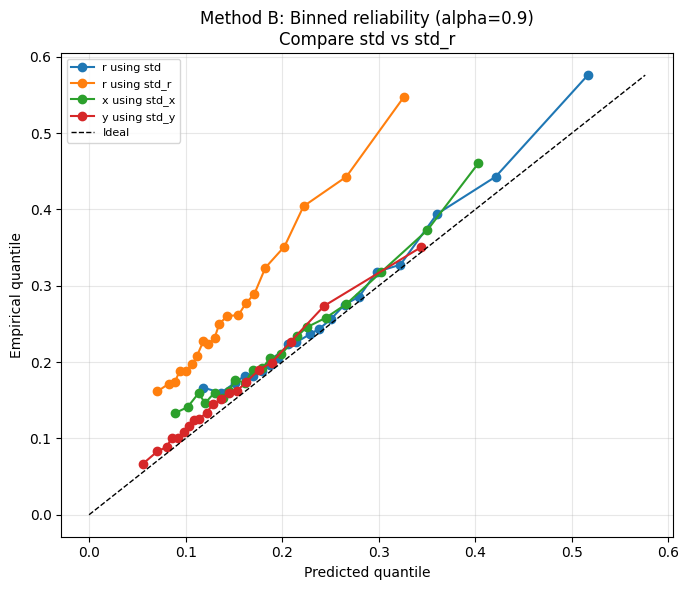

In [11]:
# -----------------------------
# Method B: Binning by uncertainty (reliability diagram)
# Compare std vs std_r (and optionally ellipse with std_x/std_y)
# -----------------------------
def make_bins_equal_count(values: np.ndarray, n_bins: int):
    values = np.asarray(values)
    qs = np.linspace(0, 1, n_bins + 1)
    edges = np.quantile(values, qs)
    for i in range(1, len(edges)):
        if edges[i] <= edges[i-1]:
            edges[i] = edges[i-1] + 1e-12
    return edges

def bin_stats(values: np.ndarray, bins: np.ndarray):
    idx = np.digitize(values, bins, right=False) - 1
    valid = (idx >= 0) & (idx < (len(bins) - 1))
    return idx, valid

def binned_reliability_1d(errors: np.ndarray, sigma: np.ndarray, n_bins: int = 20, alpha: float = 0.9):
    """Compare empirical q_alpha(|e|) with HalfNormal predicted q under N(0,sigma^2)."""
    errors = np.asarray(errors)
    sigma = np.asarray(sigma)
    valid0 = np.isfinite(errors) & np.isfinite(sigma) & (sigma > 0)
    e = np.abs(errors[valid0])
    s = sigma[valid0]
    bins = make_bins_equal_count(s, n_bins)
    idx, valid = bin_stats(s, bins)
    e, s, idx = e[valid], s[valid], idx[valid]
    out = []
    for b in range(n_bins):
        m = idx == b
        if m.sum() < 20:
            continue
        s_med = np.median(s[m])
        emp_q = np.quantile(e[m], alpha)
        pred_q = stats.halfnorm.ppf(alpha, scale=s_med)
        out.append((b, m.sum(), s_med, emp_q, pred_q))
    return pd.DataFrame(out, columns=["bin", "n", "sigma_med", "emp_q", "pred_q"])

def summarize_rel_gap(bdf: pd.DataFrame):
    return float(np.mean(np.abs(bdf["emp_q"] - bdf["pred_q"]) / (bdf["pred_q"] + 1e-12)))

alpha_bin = 0.9
n_bins = 20

plots = []

if "std" in df.columns:
    plots.append(("r using std", binned_reliability_1d(df["err_r"], df["std"], n_bins=n_bins, alpha=alpha_bin)))

if "std_r" in df.columns:
    plots.append(("r using std_r", binned_reliability_1d(df["err_r"], df["std_r"], n_bins=n_bins, alpha=alpha_bin)))

if "std_x" in df.columns and "std_y" in df.columns and "std" in df.columns:
    plots.append(("x using std_x", binned_reliability_1d(df["err_abs_x"], df["std_x"], n_bins=n_bins, alpha=alpha_bin)))
    plots.append(("y using std_y", binned_reliability_1d(df["err_abs_y"], df["std_y"], n_bins=n_bins, alpha=alpha_bin)))

print(f"alpha_bin={alpha_bin}, n_bins={n_bins}")
for name, bdf in plots:
    print(name, "| mean relative gap:", summarize_rel_gap(bdf))

plt.figure(figsize=(7, 6))
for name, bdf in plots:
    plt.plot(bdf["pred_q"], bdf["emp_q"], "o-", label=name)

mx = max([bdf[["pred_q", "emp_q"]].to_numpy().max() for _, bdf in plots]) if plots else 1.0
plt.plot([0, mx], [0, mx], "k--", lw=1, label="Ideal")
plt.xlabel("Predicted quantile")
plt.ylabel("Empirical quantile")
plt.title(f"Method B: Binned reliability (alpha={alpha_bin})\nCompare std vs std_r")
plt.grid(True, alpha=0.3)
plt.legend(fontsize=8)
plt.tight_layout()
plt.show()